# Time Series Fitting and Forecasting with a QNN (Demo)

### Author
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Aims
> *This script aims to fit time series data with quantum neural network.*

### Primary Sources
- Schreiber, Amelie. “Quantum Neural Networks for FinTech.” 
    Medium, May 8, 2020.<br/> 
    https://towardsdatascience.com/quantum-neural-networks-for-fintech-dddc6ac68dbf
- Qiskit Team. "Tutorial: Neural Network Classifier & Regressor", Last updated: 31 Aug 2022.<br/>
    https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/Dropbox/Dev/Python/qiskit/projects/ts/tqcebt_qtsa',
 '/home/jacob/anaconda3/envs/qiskit/lib/python38.zip',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/lib-dynload',
 '',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages/IPython/extensions',
 '/home/jacob/.ipython',
 '.']

In [2]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, P_BFGS, QNSPSA
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit_machine_learning.algorithms.regressors import VQR #, NeuralNetworkRegressor

import matplotlib.pyplot as plt
import numpy as np
import pylab
from IPython.display import clear_output
%matplotlib inline

from utils import *

In [3]:
debug = True

## Create a data set

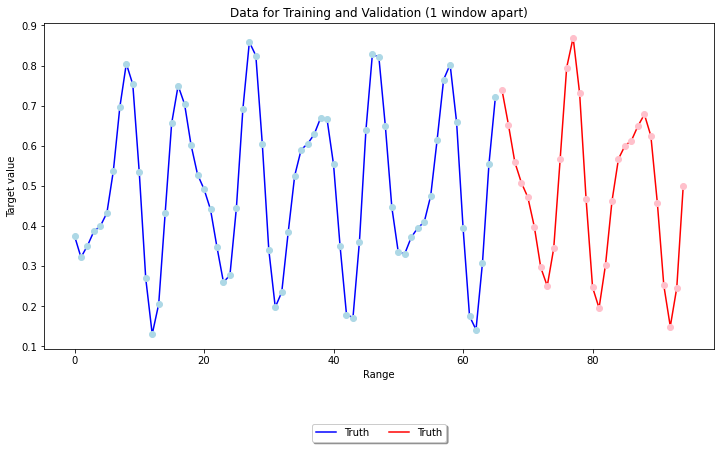

In [4]:
### Start random process
algorithm_globals.random_seed = 2022

### Data settings
samples = 50
train_pc = 0.7
samples_train = int(np.round(samples * train_pc, 0))
samples_valid = samples - samples_train
samples_hi_res = samples*2

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 5
wind_step = 1
horizon = 1

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

### Define a target function params
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
eps = f.eps()
T = (ub - lb)

### Prepare all X and y data
X_all = np.linspace(lb, ub, num=samples_hi_res)
y_all = f.fun(X_all)

# Prepare X and y for training
X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = Xy_wind_split(y_all, wind_size, wind_step, horizon, train_pc)

# Plot prepared data
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Data for Training and Validation (1 window apart)")
plt.xlabel("Range")
plt.ylabel("Target value")
# plt.xlim(lb, ub)

# Plot target function
plt.plot(range(X_train_ts.shape[0]), [y[0] for y in y_train_ts], color='blue', label='Truth')
plt.plot(range(X_train_ts.shape[0]), [y[0] for y in y_train_ts], marker='o', color='lightblue', linestyle='None')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0]), [y[0] for y in y_valid_ts], color='red', label='Truth')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0]), [y[0] for y in y_valid_ts], marker='o', color='pink', linestyle='None')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

## Prepare windowed version of data

In [5]:
from pprint import pprint

### Show a sample of data
print('\nOriginal training examples (20 y values, X is ignored):')
pprint(y_all[0:20])
print('\nTS X train examples (5 records):')
pprint(X_train_ts[0:5,:])
print('\nTS y train examples (5 records):')
pprint(y_train_ts[0:5,:])
print('\nTS X, y train shape:', X_train_ts.shape, y_train_ts.shape)
print('TS X, y valid shape:', X_valid_ts.shape, y_valid_ts.shape, '\n')


Original training examples (20 y values, X is ignored):
array([0.5       , 0.75444266, 0.85072478, 0.74813221, 0.54229474,
       0.37529953, 0.32180385, 0.35086342, 0.3869433 , 0.40005637,
       0.43250985, 0.53759593, 0.69649509, 0.80470206, 0.75302619,
       0.5335143 , 0.26909808, 0.13031512, 0.2050119 , 0.43217518])

TS X train examples (5 records):
array([[0.5       , 0.75444266, 0.85072478, 0.74813221, 0.54229474],
       [0.75444266, 0.85072478, 0.74813221, 0.54229474, 0.37529953],
       [0.85072478, 0.74813221, 0.54229474, 0.37529953, 0.32180385],
       [0.74813221, 0.54229474, 0.37529953, 0.32180385, 0.35086342],
       [0.54229474, 0.37529953, 0.32180385, 0.35086342, 0.3869433 ]])

TS y train examples (5 records):
array([[0.37529953],
       [0.32180385],
       [0.35086342],
       [0.3869433 ],
       [0.40005637]])

TS X, y train shape: (66, 5) (66, 1)
TS X, y valid shape: (29, 5) (29, 1) 



## Classical MLP Solution (sklearn)

In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve
from sklearn.metrics import r2_score, mean_absolute_percentage_error 

### Prep data for performance testing
Xt = X_train_ts
yt = y_train_ts.reshape(y_train_ts.shape[0],)

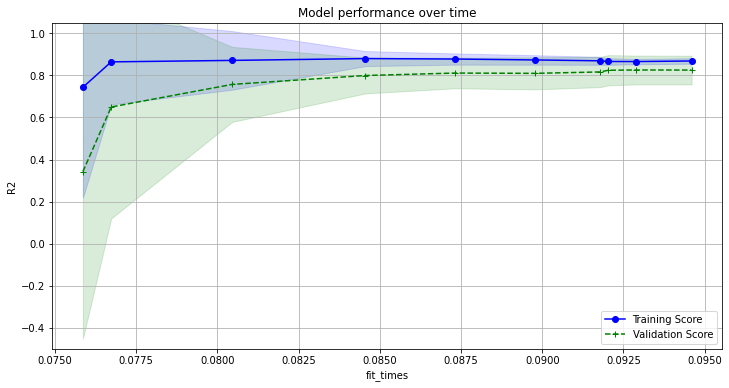

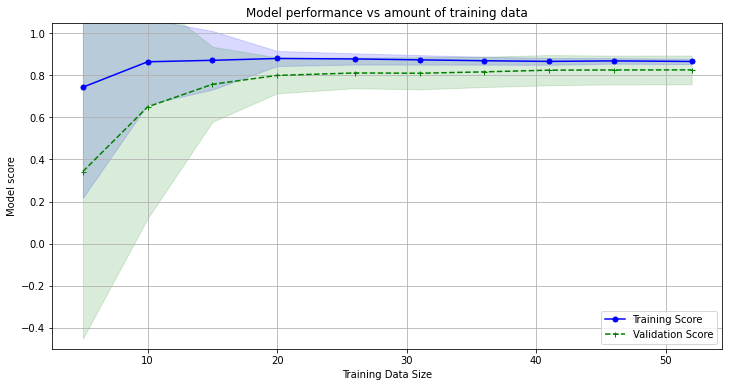

In [7]:
### Learning curves (slow)

# Create a model for performance testing
estimator = MLPRegressor(hidden_layer_sizes=(150,100,50), random_state=2022, max_iter=2000, activation = 'relu',
                       solver = 'adam', shuffle=True)

# Train model and collect curves
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator, Xt, yt, scoring='r2', cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    n_jobs=4, train_sizes=np.linspace(0.1, 1.0, 10), return_times=True)

# Calculate training and test mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Plot learning curve: time vs score
fit_time_argsort = fit_times_mean.argsort()
fit_time_sorted = fit_times_mean[fit_time_argsort]
train_scores_mean_sorted = train_scores_mean[fit_time_argsort]
train_scores_std_sorted = train_scores_std[fit_time_argsort]
test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
test_scores_std_sorted = test_scores_std[fit_time_argsort]

plt.plot(fit_time_sorted, train_scores_mean_sorted, 
         color='blue', marker='o', linestyle='-', label='Training Score')
plt.plot(fit_time_sorted, test_scores_mean_sorted, 
         color='green', marker='+', linestyle='--', label='Validation Score')
plt.fill_between(fit_time_sorted, train_scores_mean_sorted - train_scores_std_sorted, 
                 train_scores_mean_sorted + train_scores_std_sorted, alpha=0.15, color='blue')
plt.fill_between(fit_time_sorted, test_scores_mean_sorted - test_scores_std_sorted, 
                 test_scores_mean_sorted + test_scores_std_sorted, alpha=0.15, color='green')
plt.xlabel('fit_times')
plt.ylabel('R2')
plt.ylim(-0.5, 1.05)
plt.grid()
plt.legend(loc='lower right')
plt.title('Model performance over time')
plt.show()


# Plot the learning curve: training data vs model score
plt.plot(train_sizes, train_scores_mean, 
         color='blue', marker='o', markersize=5, linestyle='-', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean + train_scores_std, 
                 train_scores_mean - train_scores_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_scores_mean, 
         color='green', marker='+', markersize=5, linestyle='--', label='Validation Score')
plt.fill_between(train_sizes, test_scores_mean + test_scores_std, 
                 test_scores_mean - test_scores_std, alpha=0.15, color='green')
plt.title('Model performance vs amount of training data')
plt.xlabel('Training Data Size')
plt.ylabel('Model score')
plt.ylim(-0.5, 1.05)
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [8]:
regr = MLPRegressor(hidden_layer_sizes=(150,100,50), random_state=2022, max_iter=2000, activation = 'relu',
                       solver = 'adam', shuffle=True).fit(X_train_ts, y_train_ts.reshape(y_train_ts.shape[0],))
yp_train_hat = regr.predict(X_train_ts)
yp_valid_hat = regr.predict(X_valid_ts)

print('Training   score:\t', regr.score(X_train_ts, y_train_ts))
print('MAPE for training:\t', mean_absolute_percentage_error(y_train_ts, yp_train_hat), '\n')

print('Validation score:\t', regr.score(X_valid_ts, y_valid_ts))
print('MAPE for validation:\t', mean_absolute_percentage_error(y_valid_ts, yp_valid_hat))

Training   score:	 0.8648267887139258
MAPE for training:	 0.14756402645737268 

Validation score:	 0.8484610739451987
MAPE for validation:	 0.15424883311586987


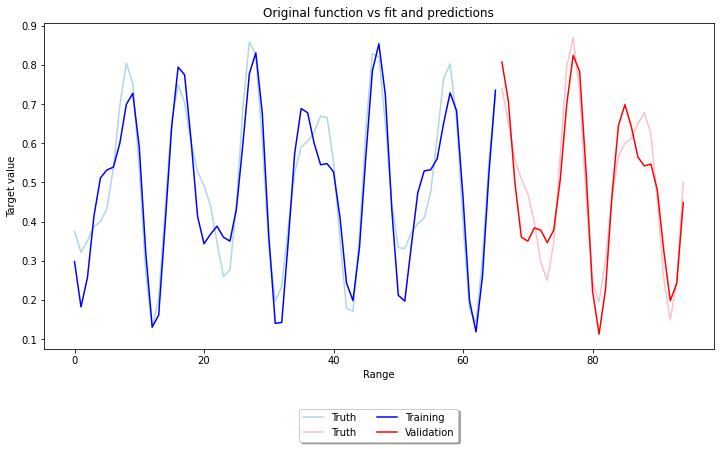

In [9]:
# Prepare the plot
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Original function vs fit and predictions")
plt.xlabel("Range")
plt.ylabel("Target value")
# plt.xlim(lb, ub)

# Plot target function
offset = wind_size-1
plt.plot(range(X_train_ts.shape[0]), [y[0] for y in y_train_ts], color='lightblue', label='Truth')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0]), [y[0] for y in y_valid_ts], color='pink', label='Truth')

# Plot all predictions
plt.plot(range(X_train_ts.shape[0]), yp_train_hat, color='blue', label='Training')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0]), yp_valid_hat, color='red', label='Validation')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

## Regression with the Quantum Neural Network - Variational Quantum Regressor (VQR)

VQR is a variant of the NeuralNetworkRegressor with a OpflowQNN, which allows to define observables for measurement.</br>
See: https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/operators/01_operator_flow.ipynb

In [10]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100, seed_simulator=2022, seed_transpiler=2022)

### Define the QNN for the time series

In [11]:
### Define the structure of VQR components
#   - Note that we must have the same size window as the number of qubits
qubits_no = wind_size
fm_layers_no = 1 # Layers for feature map
ans_layers_no = 2 # Layers for ansatz

# construct a simple feature map
def fmap_ry(qubits_no):
    ansatz = QuantumCircuit(qubits_no, name="ry")
    for q in range(qubits_no):
        param_x = Parameter("x["+str(q)+"]")
        ansatz.ry(param_x, q)
    return ansatz

# Define what is observable (qubit projection onto Z, or identity I)
obs_encoding_0 = "I"*(qubits_no - horizon) + "Z"*horizon
obs_encoding_all = "Z"*qubits_no
observable = PauliSumOp.from_list([(obs_encoding_all, 1)])

# Several possible feature maps and ansatze
zzf_map = ZZFeatureMap(qubits_no, reps=fm_layers_no, insert_barriers=True)
ryf_map = fmap_ry(qubits_no)
pauli_map_xyz = PauliFeatureMap(qubits_no, reps=fm_layers_no, paulis=['Z', 'YY', 'ZXZ'])
pauli_map_xy = PauliFeatureMap(qubits_no, reps=fm_layers_no, paulis=['Z', 'Y', 'X'])
ra_ansatz = RealAmplitudes(qubits_no, entanglement="full", reps=ans_layers_no, insert_barriers=True)
effsu2_ansatz = EfficientSU2(qubits_no, reps=ans_layers_no, entanglement="full", insert_barriers=True)
effsu2_ansatz_u = EfficientSU2(qubits_no, reps=ans_layers_no, entanglement="full", su2_gates=['rx', 'ry', 'rz'], insert_barriers=True)
effsu2_ansatz_yz = EfficientSU2(qubits_no, reps=ans_layers_no, entanglement="full", su2_gates=['ry', 'rz'], insert_barriers=True)
effsu2_ansatz_xy = EfficientSU2(qubits_no, reps=ans_layers_no, entanglement="full", su2_gates=['rx', 'ry'], insert_barriers=True)

# Selected feature map and ansatz
selected_map = zzf_map
selected_ansatz = ra_ansatz

Selected observable: [ True  True  True  True  True]


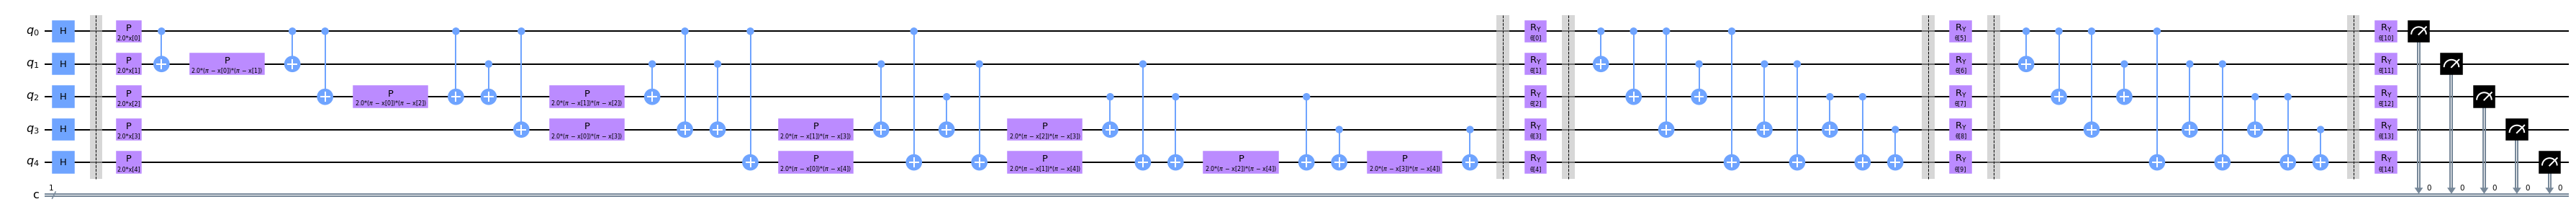

In [12]:
### This is the QNN that we will be testing
observable_flags = observable.primitive.paulis.z[0]
print('Selected observable:', observable_flags)

circ = QuantumCircuit(qubits_no, 1, name="circ")
circ.append(selected_map, qargs=selected_map.qubits)
circ.barrier()
circ.append(selected_ansatz, qargs=selected_ansatz.qubits)
for q in range(len(observable_flags)):
    if observable_flags[q]: circ.measure(q, 0)
circ.decompose().decompose().draw(output='mpl', scale=1, fold=False)

### Create the QNN and train it

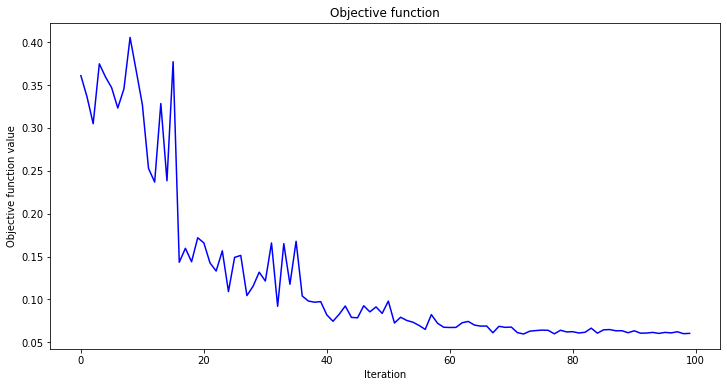

Minimum objective function value: (72, 0.059661515978952126)


In [13]:
# Start random process
algorithm_globals.random_seed = 2022

# Recommended optimizers and their parameters:  
#   COBYLA() # COBYLA(maxiter=300) # COBYLA(maxiter=500) - very fast
#   NELDER_MEAD() # NELDER_MEAD(maxiter=100) # NELDER_MEAD(maxiter=500) - slower
#   L_BFGS_B() # L_BFGS_B(maxiter=10) # L_BFGS_B(maxiter=16) - slowwweeer
# Not recommended: 
#   ADAM(maxiter=100) - slow/no callbacks
#   UMDA(maxiter=200) - slow/incorrect callbacks
optimizer = COBYLA(maxiter=100)
qnn_callback = Regr_callback()
qnn_callback.reset(obfun=[])

vqr = VQR(
    feature_map=selected_map,
    ansatz=selected_ansatz,
    optimizer=optimizer,
    observable = observable, 
    quantum_instance=quantum_instance,
    callback=qnn_callback.graph,
)

# fit regressor
vqr.fit(X_train_ts, y_train_ts)

### Find the optimum objective fun value
print('Minimum objective function value:', qnn_callback.min_obj())

## Score the model

In [14]:
### Calculate the score

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

print('R2 for pred vs training data:\t\t', vqr.score(X_train_ts, y_train_ts))
print('MAPE for pred vs training data:\t\t', mean_absolute_percentage_error(y_train_ts, vqr.predict(X_train_ts)))

print('R2 for pred vs validation data:\t\t', vqr.score(X_valid_ts, y_valid_ts))
print('MAPE for pred vs validation data:\t', mean_absolute_percentage_error(y_valid_ts, vqr.predict(X_valid_ts)))

R2 for pred vs training data:		 -0.5385181579096068
MAPE for pred vs training data:		 0.4467881210112085
R2 for pred vs validation data:		 -0.9093489495147995
MAPE for pred vs validation data:	 0.4919857792395849


## Plot the results

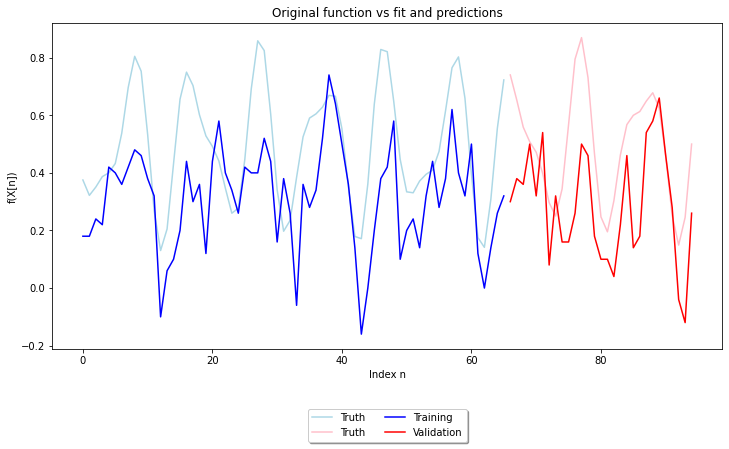

In [15]:
### Find predictions for the past and future data
yp_train_hat = vqr.predict(X_train_ts)
yp_valid_hat = vqr.predict(X_valid_ts)
offset = int(wind_size / 2)

# Prepare the plot
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Original function vs fit and predictions")
plt.xlabel("Index n")
plt.ylabel("f(X[n])")
# plt.xlim(lb, ub)

# Plot target function
offset = wind_size-1
plt.plot(range(X_train_ts.shape[0]), [y[0] for y in y_train_ts], color='lightblue', label='Truth')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0], 1), [y[0] for y in y_valid_ts], color='pink', label='Truth')

# Plot all predictions
plt.plot(range(X_train_ts.shape[0]), yp_train_hat, color='blue', label='Training')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0], 1), yp_valid_hat, color='red', label='Validation')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

### Versions
- V1 (2/9/2022)<br/>
    Commenced work on a VQR time-series fit in Qiskit, based on Qiskit tutorial and Amelie Schreiber's FinTech example (at the top of this notebook).
    - V1.1 - Experimented with the 1 qubit QNN based on Qiskit VQC/VQR tutorial 
    - V1.2 - Implemented a QNN based on the VQR model

In [16]:
import qiskit.tools.jupyter

%qiskit_version_table